In [1]:
import os
import cv2
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

# **Question: 4 - Camera Calibration**

## **Visualization of Images**

We first visualize the images we will use to calibrate the camera. The images are of a chessboard pattern located in the `Report/Assets/Camera-Calibration` directory. We will use these images to calibrate the camera and obtain the intrinsic matrix and distortion coefficients, and extrinsic matrix for each image, among other tasks.

In [2]:
base = r"Report/Assets/Camera-Calibration/"
images = [os.path.join(base, image) for image in os.listdir(base)]

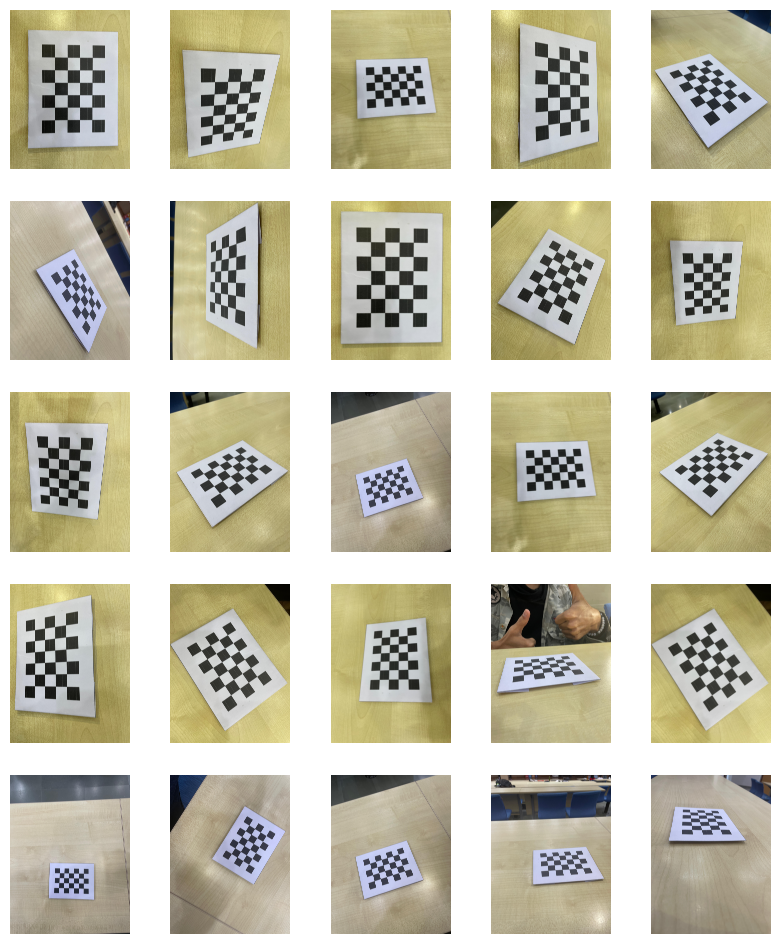

In [3]:
plt.figure(figsize=(10, 12))
for i, image in enumerate(images):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

## **Parameter Estimation: Intrinsic, Extrinsic, and Distortion**

In this section, we estimate the intrinsic parameters of the camera using the above images (and the extrinsic parameters for each) and the `cv2` library. The intrinsic parameters include the focal length, the principal point, and the skew coefficient. The extrinsic parameters include the rotation matrices and the translation vectors. The distortion parameters (radial and tangential) are also estimated.

In [4]:
CHESSBOARD = (4, 6)
FRAME_SIZE = (4032, 3024)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
flag = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE

objp = np.zeros((CHESSBOARD[0]*CHESSBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[:CHESSBOARD[0], :CHESSBOARD[1]].T.reshape(-1, 2)

objpoints = []
imgpoints = []
processed = {}

for image_path in images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD, flag)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        processed[image_path] = cv2.drawChessboardCorners(image, CHESSBOARD, corners2, ret)
        print("Processed:", image_path)
    else:
        print("Corners not found in:", image_path)

Processed: Report/Assets/Camera-Calibration/01.jpg
Processed: Report/Assets/Camera-Calibration/02.jpg
Processed: Report/Assets/Camera-Calibration/03.jpg
Processed: Report/Assets/Camera-Calibration/04.jpg
Processed: Report/Assets/Camera-Calibration/05.jpg
Processed: Report/Assets/Camera-Calibration/06.jpg
Processed: Report/Assets/Camera-Calibration/07.jpg
Processed: Report/Assets/Camera-Calibration/08.jpg
Processed: Report/Assets/Camera-Calibration/09.jpg
Processed: Report/Assets/Camera-Calibration/10.jpg
Processed: Report/Assets/Camera-Calibration/11.jpg
Processed: Report/Assets/Camera-Calibration/12.jpg
Processed: Report/Assets/Camera-Calibration/13.jpg
Processed: Report/Assets/Camera-Calibration/14.jpg
Processed: Report/Assets/Camera-Calibration/15.jpg
Processed: Report/Assets/Camera-Calibration/16.jpg
Processed: Report/Assets/Camera-Calibration/17.jpg
Processed: Report/Assets/Camera-Calibration/18.jpg
Processed: Report/Assets/Camera-Calibration/19.jpg
Processed: Report/Assets/Camera

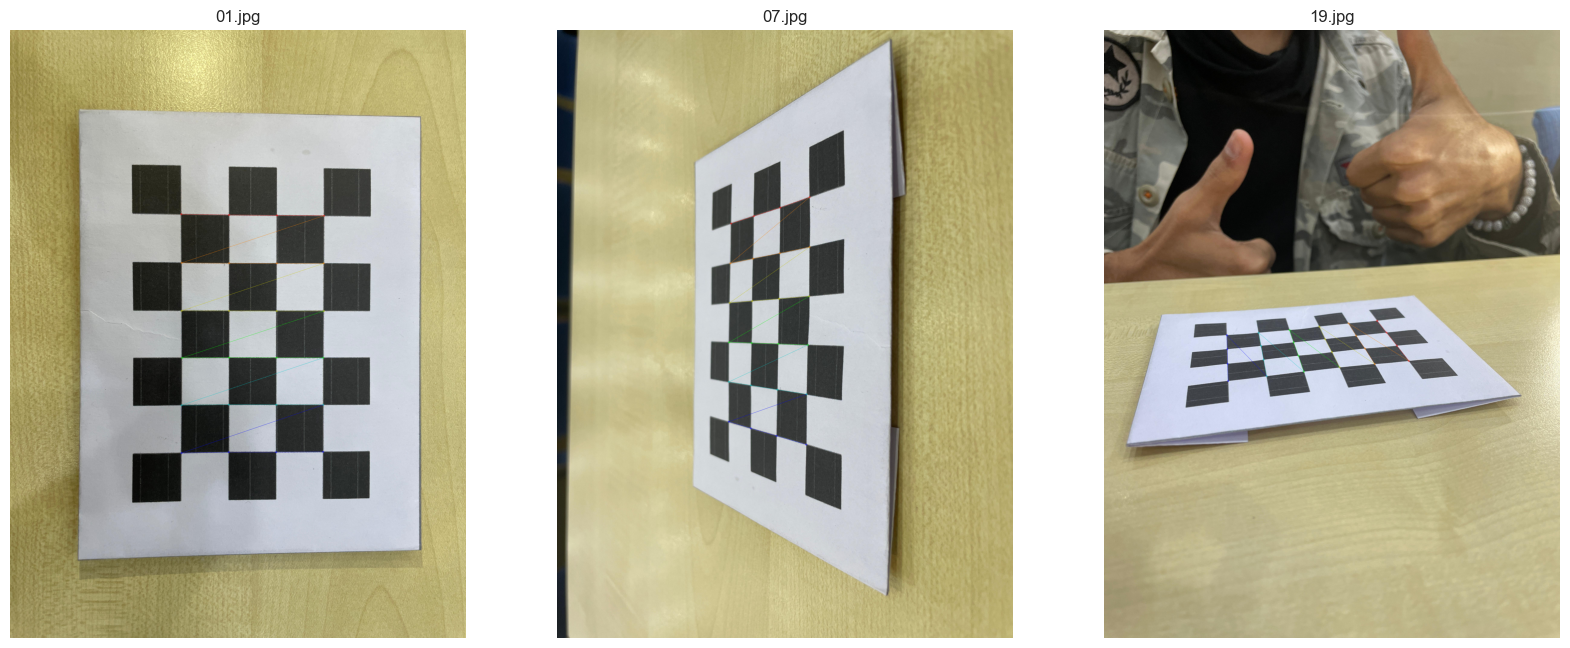

In [5]:
plt.figure(figsize=(20, 10))
for i, index in enumerate([0, 6, 18]):
    plt.subplot(1, 3, i+1)
    plt.title(images[index].split("/")[-1])
    plt.imshow(cv2.cvtColor(processed[images[index]], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

In [6]:
ret, camera_matrix, distortion, rotations, translations = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if not ret:
    print("Calibration failed. Use more images.")

In [7]:
np.save("camera-matrix.npy", camera_matrix)
np.save("distortion.npy", distortion)
np.save("rotations.npy", rotations)
np.save("translations.npy", translations)

with open("camera-calibration.pkl", "wb") as file:
    pickle.dump(objpoints, file)
    pickle.dump(imgpoints, file)
    pickle.dump(processed, file)
    pickle.dump(gray.shape[::-1], file)

In [3]:
# camera_matrix = np.load("camera-matrix.npy")
# distortion = np.load("distortion.npy")
# rotations = np.load("rotations.npy")
# translations = np.load("translations.npy")

# with open("camera-calibration.pkl", "rb") as file:
#     objpoints = pickle.load(file)
#     imgpoints = pickle.load(file)
#     processed = pickle.load(file)
#     gray_shape = pickle.load(file)

### **1. Intrinsic Parameters**

The intrinsic matrix is a 3x3 matrix that contains the focal length, the principal point, and the skew coefficient. The intrinsic matrix is given by:

$$\mathbf{K} = \begin{bmatrix} f_{x} & s & c_{x} \\ 0 & f_{y} & c_{y} \\ 0 & 0 & 1 \end{bmatrix}$$

where $f_{x}$ and $f_{y}$ are the focal lengths in the $x$ and $y$ directions, $(c_{x}, c_{y})$ is the principal point, and $s$ is the skew parameter.

From the obtained matrix, we see that the focal length in the $x$ and $y$ directions is $f_{x} \approx 3128.0$ and $f_{y} \approx 3122.0$ respectively. The principal point is $(c_{x}, c_{y}) \approx (1508.0, 2014.0)$. The skew parameter is $s = 0.0$.

In [8]:
camera_matrix

array([[3.12787807e+03, 0.00000000e+00, 1.50830656e+03],
       [0.00000000e+00, 3.12205501e+03, 2.01385188e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### **2. Extrinsic Parameters**

The extrinsic parameters include the rotation matrices and the translation vectors. The extrinsic matrix is a 3x4 matrix that contains the rotation matrix and the translation vector. The extrinsic matrix is given by:

$$\begin{bmatrix} \mathbf{R} \mid t \end{bmatrix}$$

where $\mathbf{R}$ is the rotation matrix and $t$ is the translation vector for the image. The following code cell contains the code to get the estimated extrinsic parameters for each image.

In [9]:
for image_path, rvec, tvec in zip(images, rotations, translations):
    print("Image:", image_path)
    print(repr(cv2.Rodrigues(rvec)[0]))
    print(repr(tvec))
    print()

Image: Report/Assets/Camera-Calibration/01.jpg
array([[ 9.99435523e-01, -1.29694459e-03, -3.35701322e-02],
       [ 7.15700530e-04,  9.99849732e-01, -1.73205504e-02],
       [ 3.35875515e-02,  1.72867472e-02,  9.99286268e-01]])
array([[-1.17209071],
       [-2.48891648],
       [ 9.93189286]])

Image: Report/Assets/Camera-Calibration/02.jpg
array([[ 0.95896571, -0.09043891, -0.26871095],
       [-0.0286169 ,  0.91204514, -0.40909013],
       [ 0.28207418,  0.39999308,  0.87203194]])
array([[-1.0798664 ],
       [-0.49752448],
       [ 9.09974015]])

Image: Report/Assets/Camera-Calibration/03.jpg
array([[ 0.08373173, -0.90214412, -0.42323161],
       [ 0.97238545,  0.16681971, -0.16321064],
       [ 0.21784289, -0.39787835,  0.89119992]])
array([[-13.16402874],
       [-23.48870808],
       [ 48.40950507]])

Image: Report/Assets/Camera-Calibration/04.jpg
array([[ 0.89699596,  0.00484045, -0.44201224],
       [ 0.00832168,  0.99957792,  0.0278339 ],
       [ 0.44196041, -0.02864518,  0.8

### **3. Distortion Parameters**

Using the function `cv2.calibrateCamera`, we also obtain the radial distortion parameters. The distortion parameters are given by:

$$\mathbf{D} = \begin{bmatrix} k_{1} & k_{2} & p_{1} & p_{2} & k_{3} \end{bmatrix}$$

where $k_{1}, k_{2}, k_{3}$ are the radial distortion parameters, and $p_{1}, p_{2}$ are the tangential distortion parameters. We then try to undistort 5 images using the obtained distortion parameters. From the code cell below, the radial distortion parameters are approximately $k_{1} \approx 0.22$, $k_{2} \approx -1.14$, and $k_{3} \approx 1.0$.

In [10]:
k1, k2, p1, p2, k3 = np.round(distortion, 4).ravel()
print("Distortion Coefficients:")
print("Radial Distortion Coefficients (k1, k2, k3):", k1, k2, k3)
print("Tangential Distortion Coefficients (p1, p2):", p1, p2)

Distortion Coefficients:
Radial Distortion Coefficients (k1, k2, k3): 0.2226 -1.1407 0.9831
Tangential Distortion Coefficients (p1, p2): -0.001 -0.001


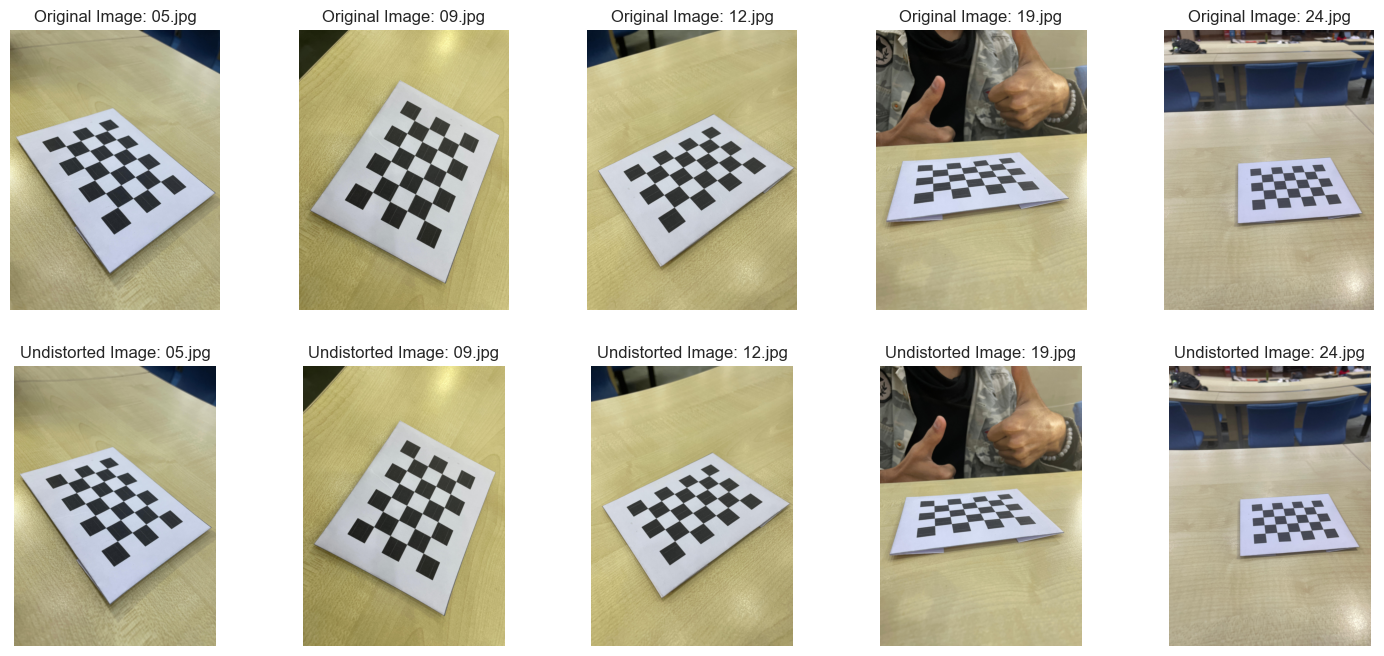

In [11]:
plt.figure(figsize=(18, 8))

for i, index in enumerate([4, 8, 11, 18, 23]):
    image = cv2.cvtColor(cv2.imread(images[index]), cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    new_camera_matrix, (x, y, w, h) = cv2.getOptimalNewCameraMatrix(camera_matrix, distortion, (width, height), 1, (width, height))
    undistorted_image = cv2.undistort(image, camera_matrix, distortion, None, new_camera_matrix)
    undistorted_image = undistorted_image[y:y+h, x:x+w]
    plt.subplot(2, 5, i+1)
    plt.title(f"Original Image: {images[index].split('/')[-1]}")
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.title(f"Undistorted Image: {images[index].split('/')[-1]}")
    plt.imshow(undistorted_image)
    plt.axis("off")

plt.show()

## **Reprojection Error**

In this section, we deal with the reprojection error of the images and the calibration. We generate bar plots of the reprojection errors for the images, and visualize the image corners and the reprojected corners.

### **4. Computing Reprojection Errors and Visualization**

We compute the mean and standard deviation of the reprojectione errors and plot the reprojection errors for each image on a bar plot.

In [12]:
errors = []
for objpoint, imgpoint, rvec, tvec in zip(objpoints, imgpoints, rotations, translations):
    projected_points, _ = cv2.projectPoints(objpoint, rvec, tvec, camera_matrix, distortion)
    error = cv2.norm(imgpoint, projected_points, cv2.NORM_L2) / len(projected_points)
    errors.append(error)

print("Mean Reprojection Error:", np.mean(errors))
print("Standard Deviation of Reprojection Error:", np.std(errors))

Mean Reprojection Error: 0.40536072402484197
Standard Deviation of Reprojection Error: 0.16749194943632384


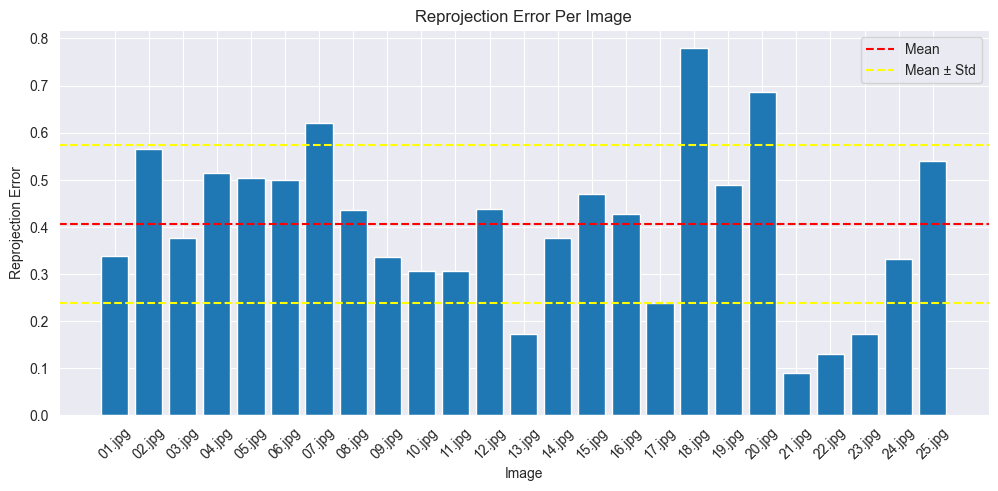

In [13]:
plt.figure(figsize=(12, 5))

plt.bar(range(len(errors)), errors)
plt.title("Reprojection Error Per Image")
plt.xlabel("Image")
plt.ylabel("Reprojection Error")
plt.xticks(range(len(errors)), [image.split("/")[-1] for image in images], rotation=45)

mean, std = np.mean(errors), np.std(errors)
plt.axhline(mean, color="red", linestyle="--", label=f"Mean")
plt.axhline(mean+std, color="yellow", linestyle="--")
plt.axhline(mean-std, color="yellow", linestyle="--", label=f"Mean \u00B1 Std")

plt.grid(True)
plt.legend()
plt.show()

### **5. Visualization of Image Corners and Reprojected Corners**

We visualize the image corners and the reprojected corners for each image. The reprojected corners are obtained using the estimated intrinsic and extrinsic parameters. The reprojected corners are close to the detected corners. 

The reprojection error for a single image is given by

$$\mathbf{e}(\mathbf{c}, \mathbf{c'}) = \frac{1}{N} \sum_{i=1}^{N} \left\| \mathbf{c}_{i} - \mathbf{c'}_{i} \right\|_{2}$$

where $\mathbf{c}$ is a collection of detected corners, $\mathbf{c'}$ is a collection of the reprojected corners, and $N$ is the number of corners. In the following plots, the red crosses are the detected corners, while the blue circles are the reprojected corners. 

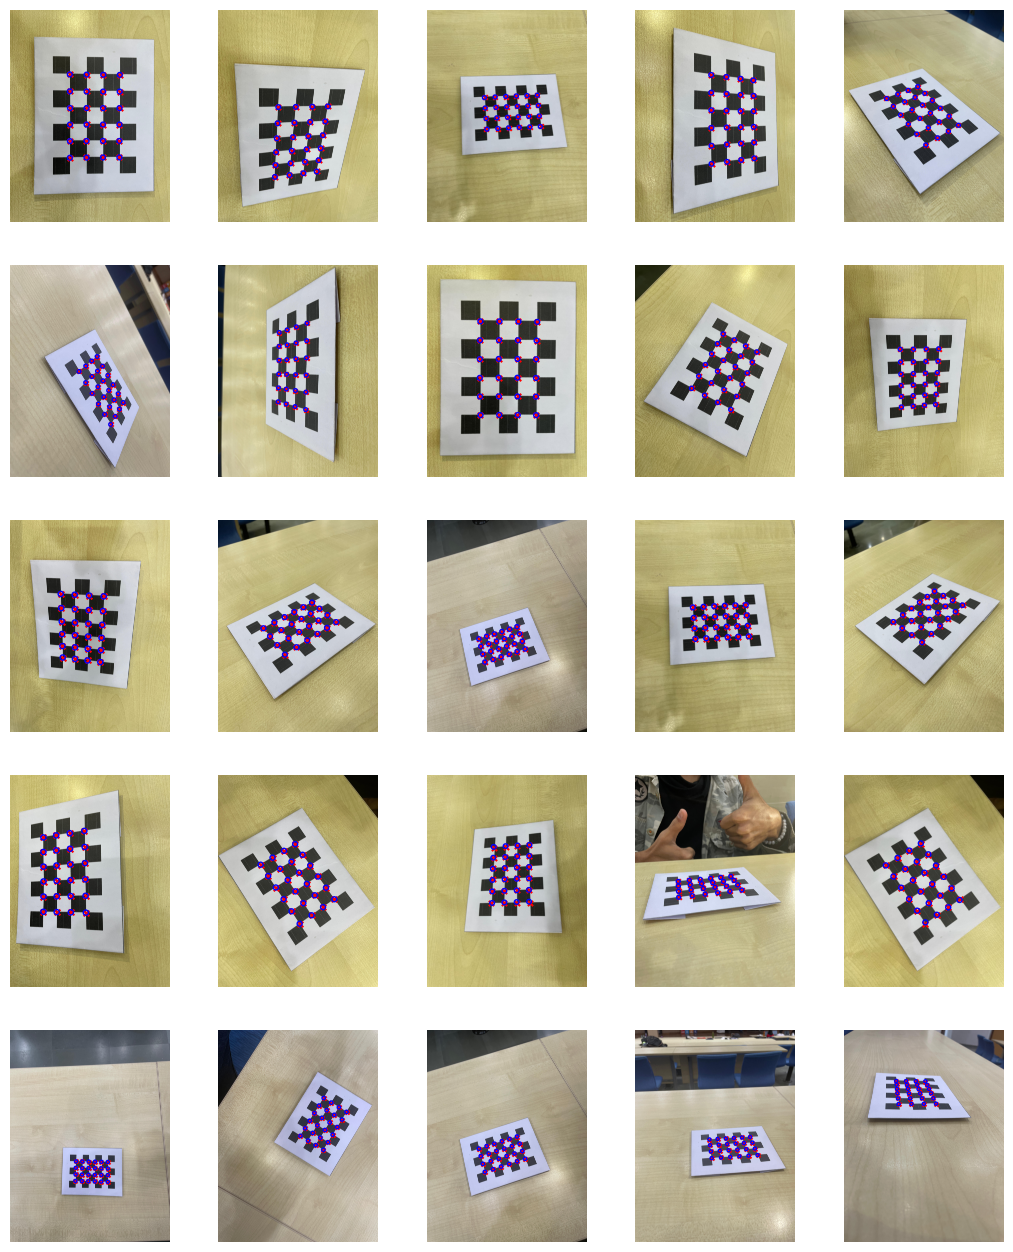

In [6]:
scatter_sizes = [12, 11, 8, 11, 8, 7, 7, 12, 9, 8, 14, 12, 9, 12, 10, 14, 13, 11, 8, 13, 5, 6, 6, 5, 5]
plt.figure(figsize=(13, 16))

for i, image_path in enumerate(images):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    corners = imgpoints[i].reshape(-1, 2)
    projections, _ = cv2.projectPoints(objpoints[i], rotations[i], translations[i], camera_matrix, distortion)
    projections = projections.reshape(-1, 2)

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.scatter(corners[:, 0], corners[:, 1], s=scatter_sizes[i]+3, color="red", marker="x")
    plt.scatter(projections[:, 0], projections[:, 1], s=scatter_sizes[i], facecolors="none", edgecolors="blue", marker="o")
    plt.axis("off")

plt.show()

## **Calculating Chessboard Normals**

In this section, we calculate the normals of the chessboard and visualize them.

### **6. Calculating Normals of Chessboard Planes**

We calculate the normals of the chessboard planes for every image using in the camera coordinate frame the estimated rotation matrix. The normal to the chessboard in the camera coordinate frame is the last column of the rotation matrix.

In [15]:
for image_path, rvec in zip(images, rotations):
    R, _ = cv2.Rodrigues(rvec)
    normal = R[:, 2]
    normal /= np.linalg.norm(normal)
    print(f"Normal of Image: {image_path.split('/')[-1]}:", np.round(normal, 5))

Normal of Image: 01.jpg: [-0.03357 -0.01732  0.99929]
Normal of Image: 02.jpg: [-0.26871 -0.40909  0.87203]
Normal of Image: 03.jpg: [-0.42323 -0.16321  0.8912 ]
Normal of Image: 04.jpg: [-0.44201  0.02783  0.89658]
Normal of Image: 05.jpg: [-0.11372  0.65751  0.74481]
Normal of Image: 06.jpg: [-0.7171   0.28671  0.63527]
Normal of Image: 07.jpg: [0.78207 0.01565 0.62299]
Normal of Image: 08.jpg: [-0.36239 -0.44978  0.81632]
Normal of Image: 09.jpg: [-0.16711  0.32907  0.9294 ]
Normal of Image: 10.jpg: [-0.17656 -0.33128  0.92687]
Normal of Image: 11.jpg: [ 0.19024 -0.31254  0.93066]
Normal of Image: 12.jpg: [0.00542 0.65184 0.75834]
Normal of Image: 13.jpg: [0.07073 0.35785 0.9311 ]
Normal of Image: 14.jpg: [-0.42323 -0.16321  0.8912 ]
Normal of Image: 15.jpg: [0.03449 0.66268 0.74811]
Normal of Image: 16.jpg: [0.35198 0.06141 0.93399]
Normal of Image: 17.jpg: [-0.07742  0.21347  0.97388]
Normal of Image: 18.jpg: [-0.12534 -0.02096  0.99189]
Normal of Image: 19.jpg: [0.01485 0.91469 0

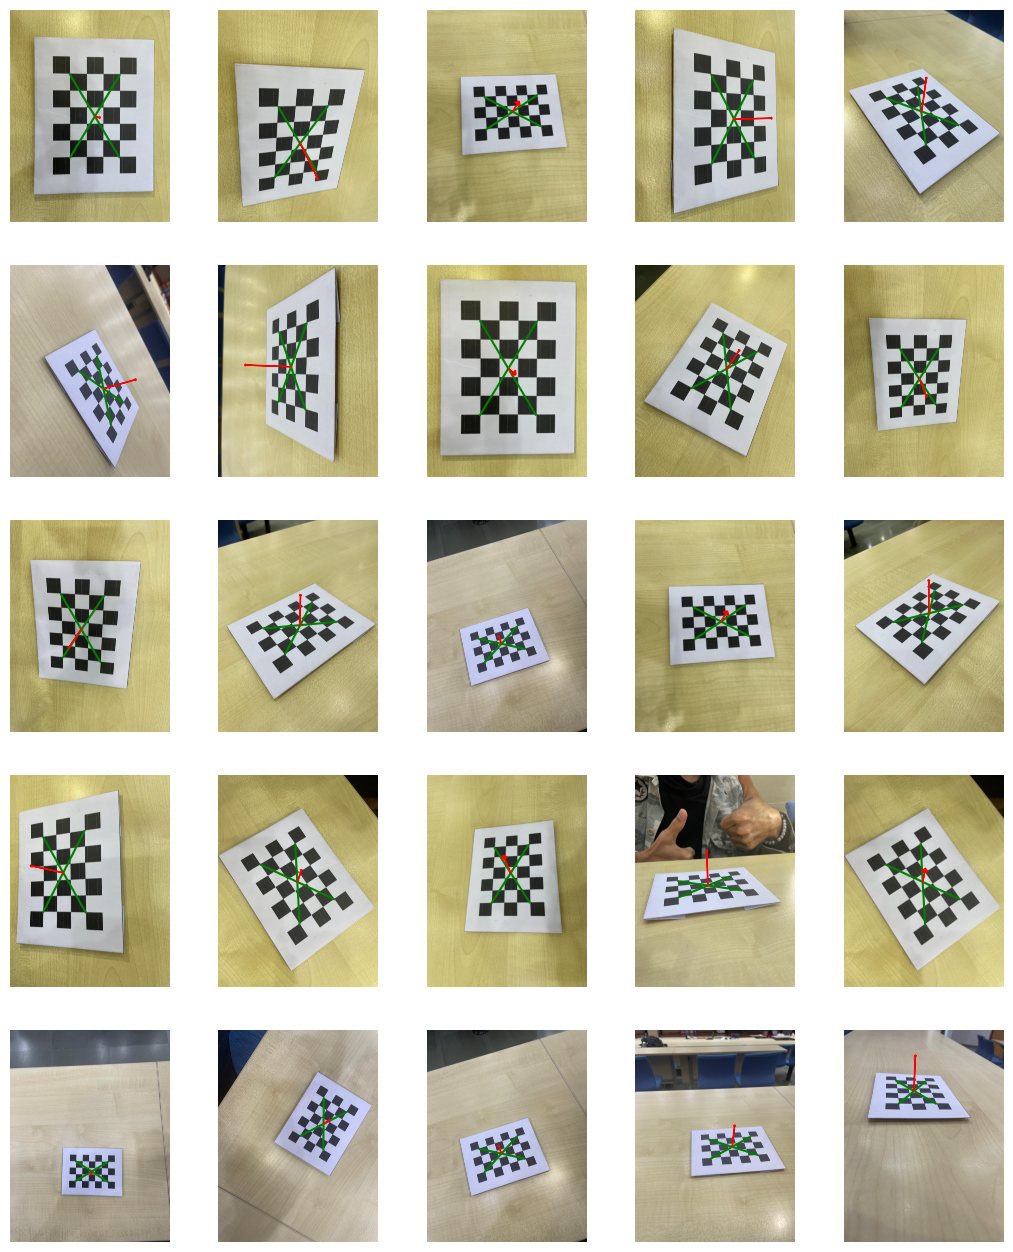

In [4]:
plt.figure(figsize=(13, 16))

for i, image_path in enumerate(images):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    corners = imgpoints[i].reshape(-1, 2)

    center = np.mean(objpoints[i], axis=0)
    z = np.array([center[0], center[1], -3], dtype=float).reshape(1, 3)
    projected, _ = cv2.projectPoints(z, rotations[i], translations[i], camera_matrix, distortion)
    projected = projected.reshape(-1, 2)

    center = np.mean(corners, axis=0)
    normal = np.array([center, projected[0]])

    on_plane_1 = np.array([corners[0], corners[23]])
    on_plane_2 = np.array([corners[3], corners[20]])

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.plot(on_plane_1[:, 0], on_plane_1[:, 1], color="green", linewidth=1.5, zorder=0)
    plt.plot(on_plane_2[:, 0], on_plane_2[:, 1], color="green", linewidth=1.5, zorder=0)
    plt.arrow(normal[0, 0], normal[0, 1], normal[1, 0]-normal[0, 0], normal[1, 1]-normal[0, 1], head_width=40, head_length=20, fc="red", ec="red")
    plt.axis("off")

plt.show()